In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ADANIPORTS.csv to ADANIPORTS.csv


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import concatenate
from keras.optimizers import Adagrad

<ipython-input-50-c919a3cf33ef>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


* Get the stock data from Yahoo finance as a CSV for any company. 

* Drop all other columns (Volume, Year, Month and Day) and retain Open, High and Close - since I'm just predicting the close value for a day

In [51]:
def get_stock_data(stock_name, normalized=0):
    # url = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name

    # col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv('ADANIPORTS.csv') 
    df = pd.DataFrame(stocks)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    df["Volume"] = df["Volume"] / 10000
    #df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True) 
    return df

In [52]:
stock_name = 'ADANIPORTS'
df = get_stock_data(stock_name,0)
df.head()

<ipython-input-51-85b14a0adbe5>:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['Year'], df['Month'], df['Day'] = date_split


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Year,Month,Day
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,2729.4366,2.687719e+15,NaN,9859619,0.3612,2007,11,27
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,458.1338,4.312765e+14,NaN,1453278,0.3172,2007,11,28
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,512.4121,4.550658e+14,NaN,1069678,0.2088,2007,11,29
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,460.9762,4.283257e+14,NaN,1260913,0.2735,2007,11,30
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,297.7470,2.875200e+14,NaN,816123,0.2741,2007,12,03


In [53]:
#df.drop(df.columns[[0,1,2,3,6, 7,9,10,11,12,13,14,15,16,17]], axis=1, inplace=True)
df1=df[[ 'High','Low','Turnover','VWAP']]
df1.head()

,High,Low,Turnover,VWAP
0,1050.00,770.0,2.687719e+15,984.72
1,990.00,874.0,4.312765e+14,941.38
2,914.75,841.0,4.550658e+14,888.09
3,958.00,890.0,4.283257e+14,929.17
4,995.00,922.0,2.875200e+14,965.65


* Let me save the data to a CSV file so that I can refer later (if needed :) ) 

In [54]:
today = datetime.date.today()
filename = stock_name+'_stock_%s.csv' % today
df.to_csv(filename)

Normalizing

In [55]:
#Normalization
df2=df1
df2['Turnover']=df2['Turnover']/100000000000
df2.head()

<ipython-input-55-c5cedb4dac49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Turnover']=df2['Turnover']/100000000000


,High,Low,Turnover,VWAP
0,1050.00,770.0,26877.190538,984.72
1,990.00,874.0,4312.765302,941.38
2,914.75,841.0,4550.658463,888.09
3,958.00,890.0,4283.256628,929.17
4,995.00,922.0,2875.199743,965.65


In [56]:
#Load the data
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data =  pd.DataFrame(stock) #stock.as_matrix()
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]
def load_data2(stock, seq_len):
    amount_of_features = len(stock.columns)
    data =  pd.DataFrame(stock) #stock.as_matrix()
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    # x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    # x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [57]:
#Build the model
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,activation='relu'))        
        model.add(Dense(1,activation='linear'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model
        

Divide as Training and Test set

In [58]:
window = 22
X_train, y_train, X_test, y_test = load_data(df2[::1], window)
print("X_train", X_train)
print("y_train", y_train)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print("",X_train[23])

X_train [[[ 1050.           770.         26877.19053785   984.72      ]
  [  990.           874.          4312.76530165   941.38      ]
  [  914.75         841.          4550.65846265   888.09      ]
  ...
  [ 1214.          1148.          1735.9385654   1183.3       ]
  [ 1240.          1204.          1195.06465945  1222.58      ]
  [ 1274.          1175.          1421.7728054   1221.31      ]]

 [[  990.           874.          4312.76530165   941.38      ]
  [  914.75         841.          4550.65846265   888.09      ]
  [  958.           890.          4283.2566283    929.17      ]
  ...
  [ 1240.          1204.          1195.06465945  1222.58      ]
  [ 1274.          1175.          1421.7728054   1221.31      ]
  [ 1295.          1261.           941.94213815  1277.64      ]]

 [[  914.75         841.          4550.65846265   888.09      ]
  [  958.           890.          4283.2566283    929.17      ]
  [  995.           922.          2875.199743     965.65      ]
  ...
  [ 1274. 

In [ ]:
# model = build_model([3,lag,1])
model = build_model2([4,window,1])

Execute the trained model

In [ ]:

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=1)

Epoch 1/500
6/6 [==============================] - 5s 374ms/step - loss: 145349.8438 - accuracy: 0.0000e+00 - val_loss: 137628.1406 - val_accuracy: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 1s 229ms/step - loss: 143265.7835 - accuracy: 0.0000e+00 - val_loss: 135958.3594 - val_accuracy: 0.0000e+00
Epoch 3/500
6/6 [==============================] - 1s 231ms/step - loss: 142298.9420 - accuracy: 0.0000e+00 - val_loss: 133803.0625 - val_accuracy: 0.0000e+00
Epoch 4/500
6/6 [==============================] - 1s 226ms/step - loss: 140377.9643 - accuracy: 0.0000e+00 - val_loss: 131944.2344 - val_accuracy: 0.0000e+00
Epoch 5/500
6/6 [==============================] - 1s 230ms/step - loss: 139209.6473 - accuracy: 0.0000e+00 - val_loss: 130050.5312 - val_accuracy: 0.0000e+00
Epoch 6/500
6/6 [==============================] - 1s 223ms/step - loss: 139271.2299 - accuracy: 0.0000e+00 - val_loss: 128261.7344 - val_accuracy: 0.0000e+00
Epoch 7/500
6/6 [=============================

Train on 1055 samples, validate on 118 samples

Epoch 1/500
1055/1055 [==============================] - 6s - loss: 54.5698 - acc: 0.0000e+00 - val_loss: 56.6067 - val_acc: 0.0000e+00
Epoch 2/500
1055/1055 [==============================] - 4s - loss: 54.2361 - acc: 0.0000e+00 - val_loss: 56.1267 - val_acc: 0.0000e+00
Epoch 3/500
1055/1055 [==============================] - 3s - loss: 53.7573 - acc: 0.0000e+00 - val_loss: 55.5052 - val_acc: 0.0000e+00
Epoch 4/500
1055/1055 [==============================] - 3s - loss: 53.1317 - acc: 0.0000e+00 - val_loss: 54.6624 - val_acc: 0.0000e+00
Epoch 5/500
1055/1055 [==============================] - 3s - loss: 52.2918 - acc: 0.0000e+00 - val_loss: 53.5170 - val_acc: 0.0000e+00
Epoch 6/500
1055/1055 [==============================] - 3s - loss: 51.1431 - acc: 0.0000e+00 - val_loss: 52.0444 - val_acc: 0.0000e+00
Epoch 7/500
1055/1055 [==============================] - 3s - loss: 49.7124 - acc: 0.0000e+00 - val_loss: 50.2901 - val_acc: 0.0000e+00
Epoch 8/500
1055/1055 [==============================] - 3s - loss: 48.0304 - acc: 0.0000e+00 - val_loss: 48.4176 - val_acc: 0.0000e+00
Epoch 9/500
1055/1055 [==============================] - 3s - loss: 46.2073 - acc: 0.0000e+00 - val_loss: 46.4271 - val_acc: 0.0000e+00
Epoch 10/500
1055/1055 [==============================] - 3s - loss: 44.2880 - acc: 0.0000e+00 - val_loss: 44.3134 - val_acc: 0.0000e+00

Epoch 490/500
1055/1055 [==============================] - 6s - loss: 3.3352 - acc: 0.0000e+00 - val_loss: 0.2747 - val_acc: 0.0000e+00
Epoch 491/500
1055/1055 [==============================] - 6s - loss: 3.3220 - acc: 0.0000e+00 - val_loss: 0.3347 - val_acc: 0.0000e+00
Epoch 492/500
1055/1055 [==============================] - 6s - loss: 3.3430 - acc: 0.0000e+00 - val_loss: 0.3876 - val_acc: 0.0000e+00
Epoch 493/500
1055/1055 [==============================] - 6s - loss: 3.3882 - acc: 0.0000e+00 - val_loss: 0.3919 - val_acc: 0.0000e+00
Epoch 494/500
1055/1055 [==============================] - 6s - loss: 3.3117 - acc: 0.0000e+00 - val_loss: 0.3515 - val_acc: 0.0000e+00
Epoch 495/500
1055/1055 [==============================] - 7s - loss: 3.4429 - acc: 0.0000e+00 - val_loss: 0.3073 - val_acc: 0.0000e+00
Epoch 496/500
1055/1055 [==============================] - 7s - loss: 3.3748 - acc: 0.0000e+00 - val_loss: 0.2877 - val_acc: 0.0000e+00
Epoch 497/500
1055/1055 [==============================] - 6s - loss: 3.3394 - acc: 0.0000e+00 - val_loss: 0.2870 - val_acc: 0.0000e+00
Epoch 498/500
1055/1055 [==============================] - 6s - loss: 3.3265 - acc: 0.0000e+00 - val_loss: 0.2725 - val_acc: 0.0000e+00
Epoch 499/500
1055/1055 [==============================] - 6s - loss: 3.3056 - acc: 0.0000e+00 - val_loss: 0.2654 - val_acc: 0.0000e+00
Epoch 500/500
1055/1055 [==============================] - 6s - loss: 3.3673 - acc: 0.0000e+00 - val_loss: 0.2697 - val_acc: 0.0000e+00

In [59]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 1267.28 MSE (35.60 RMSE)
Test Score: 886.55 MSE (29.77 RMSE)


Predictions vs Real results

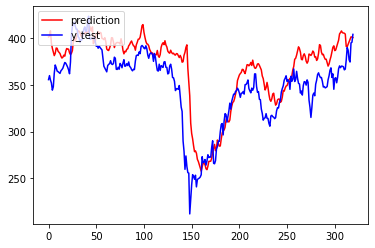

In [60]:
import matplotlib.pyplot as plt2
p=model.predict(X_test)
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()



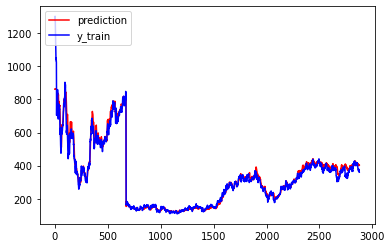

In [61]:
import matplotlib.pyplot as plt2
p=model.predict(X_train)
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_train,color='blue', label='y_train')
plt2.legend(loc='upper left')
plt2.show()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
1328


ValueError: ignored

In [167]:
from tensorflow import keras
model = keras.models.load_model('bigData_trained_model.h5')




In [168]:
small_data=pd.read_csv('small_new.csv')
df3 = small_data

In [169]:
index = df3[df3["score2"] == 'positive'].index
index1 = df3[df3["score2"] == 'neutral'].index
index2 = df3[df3["score2"] == 'negative'].index

In [170]:
df3.loc[index,"score2"] = 500
df3.loc[index1,"score2"] = 50
df3.loc[index2,"score2"] = -500

In [171]:
index = df3[df3["score1"] == 'positive'].index
index1 = df3[df3["score1"] == 'neutral'].index
index2 = df3[df3["score1"] == 'negative'].index

In [172]:
df3.loc[index,"score1"] = 500
df3.loc[index1,"score1"] = 50
df3.loc[index2,"score1"] = -500

In [173]:
df3.to_csv("small_dataval.csv")

In [174]:
d = 0.2
small_data=pd.read_csv('small_dataval.csv')
dfN=pd.DataFrame(small_data)
dfN.head()
dfL=dfN[['score1','score2','High','Low','Turnover','VWAP']]
dfL.head()
model2=Sequential()
# model2.add(LSTM(128, input_shape=(window,1), return_sequences=True))
# model2.add(Dropout(d))

model2.add(LSTM(64, input_shape=(window,1), return_sequences=False))
# model2.add(Dropout(d))
model2.add(Dense(16,activation='linear')) 
model2.add(Dense(6,activation='relu'))  
# model2.add(Dense(6,input_shape=(22,),activation='relu'))
layer1=model.get_layer(index=4)

# layer1.get_config()
# model.summary()
result = concatenate([layer1.output,model2.output]) # Merge data must same row column
output = Dense(1, activation='relu')(result)
modelL = Model(inputs=[model.input,model2.input], outputs=output)
modelL.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
modelL.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         [(None, 22, 4)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 22, 128)      68096       lstm_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, 22, 128)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_16_input (InputLayer)      [(None, 22, 1)]      0                                            
____________________________________________________________________________________________

In [175]:
from keras.utils.vis_utils import plot_model

plot_model(modelL, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [176]:
# layer1.trainable=False
# modelL.get_layer(index=1).trainable=False
# modelL.get_layer(index=3).trainable=False
modelL.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         [(None, 22, 4)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 22, 128)      68096       lstm_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, 22, 128)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_16_input (InputLayer)      [(None, 22, 1)]      0                                            
____________________________________________________________________________________________

In [177]:
df3=dfN
index = df3[df3["score2"] == 'positive'].index
index1 = df3[df3["score2"] == 'neutral'].index
index2 = df3[df3["score2"] == 'negative'].index
df3.loc[index,"score2"] = 500.0

df3.loc[index1,"score2"] = 50.0
df3.loc[index2,"score2"] = -500.0
df3["score2"] =df3["score2"].astype(float)
df3['score2']

0       50.0
1       50.0
2       50.0
3       50.0
4     -500.0
       ...  
334     50.0
335     50.0
336     50.0
337    500.0
338     50.0
Name: score2, Length: 339, dtype: float64

In [178]:
#from neuralprophet import NeuralProphet
#m = NeuralProphet()
#df.columns
# layer1.get_weights()
# modelL.get_layer('dense_14').get_weights()
window = 22
X_train2,y_train2,X_test2,y_test2=load_data2(df3[['score2']],window)
X_train2.reshape((284,22))
X_train3,y_train3,X_test3,y_test3=load_data(df3[['High','Low','Turnover','VWAP']][::1],window)
X=np.zeros((X_train2.shape[0],X_train2.shape[1]))
X=X_train2[:,:,0]
X_train4=[X_train3,X]
y_train4=y_train3
X

array([[  50.,   50.,   50., ...,   50.,   50.,  500.],
       [  50.,   50.,   50., ...,   50.,  500.,   50.],
       [  50.,   50., -500., ...,  500.,   50.,   50.],
       ...,
       [  50.,   50.,   50., ...,   50.,   50.,  500.],
       [  50.,   50.,  500., ...,   50.,  500.,   50.],
       [  50.,  500.,   50., ...,  500.,   50.,   50.]])

In [179]:


X=np.zeros((X_train2.shape[0],X_train2.shape[1]))
X=X_test2[:,:,0]
X_test4=[X_test3,X]
y_test4=y_test3

In [180]:
X_train2.shape

(284, 22, 1)

In [181]:
X_train3[0].shape

(22, 4)

In [182]:
y_train3[0]

341.69

In [183]:
modelL.fit(X_train4,y_train4,
           batch_size=50,
           epochs=300,
           validation_split=0.1,
           verbose=1)


Epoch 1/300
6/6 [==============================] - 5s 285ms/step - loss: 145091.6004 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 2/300
6/6 [==============================] - 0s 49ms/step - loss: 144899.4509 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 3/300
6/6 [==============================] - 0s 47ms/step - loss: 145606.2254 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 4/300
6/6 [==============================] - 0s 43ms/step - loss: 144778.8772 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 5/300
6/6 [==============================] - 0s 47ms/step - loss: 144513.2879 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 6/300
6/6 [==============================] - 0s 44ms/step - loss: 145541.7902 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 7/300
6/6 [==============================] - 0s 48m

Epoch 53/300
6/6 [==============================] - 0s 63ms/step - loss: 145116.1339 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 54/300
6/6 [==============================] - 0s 63ms/step - loss: 145048.3237 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 55/300
6/6 [==============================] - 0s 70ms/step - loss: 145793.0469 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 56/300
6/6 [==============================] - 0s 61ms/step - loss: 144683.1607 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 57/300
6/6 [==============================] - 0s 58ms/step - loss: 145984.6696 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 58/300
6/6 [==============================] - 0s 66ms/step - loss: 143955.7768 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 59/300
6/6 [==============================] - 

Epoch 105/300
6/6 [==============================] - 0s 55ms/step - loss: 144883.2344 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 106/300
6/6 [==============================] - 0s 59ms/step - loss: 145096.9308 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 107/300
6/6 [==============================] - 0s 58ms/step - loss: 143936.3750 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 108/300
6/6 [==============================] - 0s 77ms/step - loss: 144083.8527 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 109/300
6/6 [==============================] - 0s 67ms/step - loss: 144439.7076 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 110/300
6/6 [==============================] - 0s 63ms/step - loss: 146069.0938 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 111/300
6/6 [===========================

6/6 [==============================] - 0s 47ms/step - loss: 144803.2969 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 157/300
6/6 [==============================] - 0s 51ms/step - loss: 144363.2612 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 158/300
6/6 [==============================] - 0s 46ms/step - loss: 146069.0915 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 159/300
6/6 [==============================] - 0s 47ms/step - loss: 144919.9732 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 160/300
6/6 [==============================] - 0s 46ms/step - loss: 144691.6004 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 161/300
6/6 [==============================] - 0s 47ms/step - loss: 144952.3326 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 162/300
6/6 [==============================] - 0s 45ms

6/6 [==============================] - 0s 49ms/step - loss: 145745.0848 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 208/300
6/6 [==============================] - 0s 50ms/step - loss: 145274.7277 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 209/300
6/6 [==============================] - 0s 48ms/step - loss: 146012.2098 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 210/300
6/6 [==============================] - 0s 44ms/step - loss: 145024.4777 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 211/300
6/6 [==============================] - 0s 43ms/step - loss: 144859.8326 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 212/300
6/6 [==============================] - 0s 43ms/step - loss: 144984.5312 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 213/300
6/6 [==============================] - 0s 65ms

6/6 [==============================] - 0s 56ms/step - loss: 144434.1049 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 259/300
6/6 [==============================] - 0s 63ms/step - loss: 144506.8996 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 260/300
6/6 [==============================] - 0s 57ms/step - loss: 144833.9554 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 261/300
6/6 [==============================] - 0s 55ms/step - loss: 145144.8237 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 262/300
6/6 [==============================] - 0s 62ms/step - loss: 145288.7746 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 263/300
6/6 [==============================] - 0s 61ms/step - loss: 144683.1183 - accuracy: 0.0000e+00 - val_loss: 92620.5547 - val_accuracy: 0.0000e+00
Epoch 264/300
6/6 [==============================] - 0s 55ms

In [162]:
X_train = X_train4
y_train = y_train4
trainScore = modelL.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

X_test = X_test4
y_test = y_test4
testScore = modelL.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 139857.83 MSE (373.98 RMSE)
Test Score: 78522.69 MSE (280.22 RMSE)


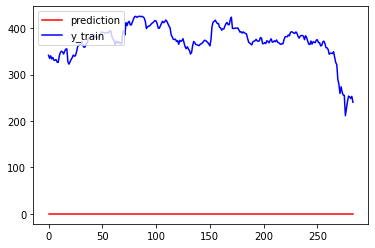

In [163]:
import matplotlib.pyplot as plt2
p=modelL.predict(X_train)
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_train,color='blue', label='y_train')
plt2.legend(loc='upper left')
plt2.show()

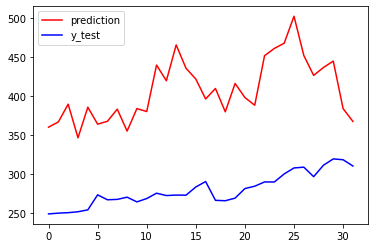

In [93]:
import matplotlib.pyplot as plt2
p=modelL.predict(X_test)
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [ ]:
# from neuralprophet import NeuralProphet
# m = NeuralProphet()
# df1= get_stock_data(stock_name,0)
# a=[]
# df2 = pd.DataFrame(a,columns=['ds','y'])
# df2['ds']=df1['Date']
# df2['y']=df1['Close']
# df2.head()
# metrics = m.fit(df2, freq="D")
# future = m.make_future_dataframe(df2, periods=60)
# forecast = m.predict(future)
# fig_forecast = m.plot(forecast)
# # fig_components = m.plot_components(forecast)
# # fig_model = m.plot_parameters()

In [ ]:
# model = NeuralProphet(
#     epochs=100,
#     learning_rate=0.1,
# )
# model.fit(df2, 
#           freq='D',
#           valid_p=0.2,
#           epochs=100)

In [ ]:
# plot_forecast(model, df2, periods=60, historic_predictions=True)  

In [ ]:
# future = model.make_future_dataframe(df2, periods=60)
# forecast = model.predict(future)
# fig_forecast = model.plot(forecast)

In [ ]:
df

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("ADANIPORTS.csv")

In [ ]:
df.info()

In [ ]:
df[df["Date"] == "2020-05-26"]

In [ ]:
k = df[2744:3088]
len(k)

In [ ]:
df2 = pd.read_csv("compressed_2.csv")

In [ ]:
df2

In [ ]:

y2 = df2[::-1].reset_index(drop=True)
y2

In [ ]:
import scipy.stats
l1 = k["Close"]
l2 = df2["score1"]
d3 = l2[0:344]

In [ ]:

len(l1)
scipy.stats.pearsonr(l1,d3)